In [4]:
import scanpy as sc
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt
import umap as umap_ext
import decoupler as dc
import numpy as np

from GraphST import GraphST

datadir = "/data1/shahs3/users/mezallj1/data/xenium"

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] ='/home/mezallj1/miniconda3/envs/graphst/lib/R'

In [5]:
def umap(adata, encoding_key="X_grafiti",n_neighbors=20,max_iter=100, min_dist=0.5, metric="euclidean", scanpy=False, neighbors_key="grafiti_neighbors", embd_name="X_umap"):
    if not scanpy:
        ldm = umap_ext.UMAP(n_epochs=max_iter,
                        n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        metric=metric)
        embd = ldm.fit_transform(adata.obsm[encoding_key])
        adata.obsm[embd_name] = embd
    else:
        sc.tl.umap(adata,neighbors_key=neighbors_key)

# GraphST - Combined

In [30]:
adata = sc.read_h5ad(f'{datadir}/raw/spectrum_xenium_normalized.h5ad')
adata

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 806626 × 477
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_genes', 'Sample_ID', 'Patient_ID', 'Treatment', 'Region', 'Site'
    obsm: 'X_pca', 'spatial'
    layers: 'log_norm'

In [31]:
adata.var_names_make_unique()

In [32]:
# define and train model
model = GraphST.GraphST(adata)
adata = model.train()

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [6:59:29<00:00, 41.95s/it]   


Optimization finished for ST data!


In [33]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

In [34]:
# the number of clusters
n_clusters = 15

In [35]:
# clustering
from GraphST.utils import clustering
clustering(adata, n_clusters, radius=radius, refinement=False) #For DLPFC dataset, we use optional refinement step.

fitting ...
  |======================================================================| 100%


In [36]:
obs_df = adata.obs.dropna()

In [37]:
umap(adata, encoding_key="emb")

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


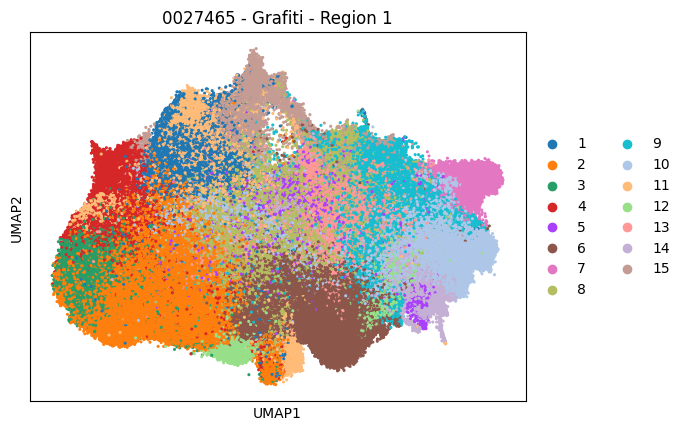

In [38]:
sc.pl.umap(adata,title="0027465 - Grafiti - Region 1",color=["domain"],s=20)

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


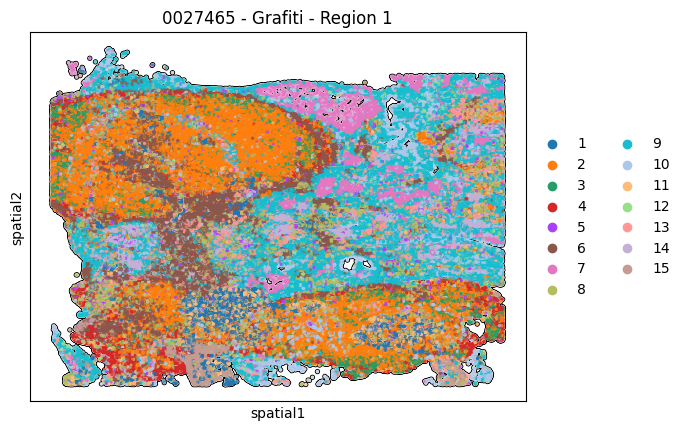

In [39]:
sc.pl.embedding(adata, basis='spatial', title = '0027465 - Grafiti - Region 1', color ='domain', s=20, add_outline=True)

In [61]:
#adata.write(f'{datadir}/graphst/spectrum_graphst_combined.h5ad')
adata = sc.read_h5ad(f'{datadir}/graphst/spectrum_graphst_combined.h5ad')

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [62]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]
# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 806626 samples and 477 targets for 24 sources.


100%|██████████| 806626/806626 [06:25<00:00, 2092.88it/s] 


In [63]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [64]:
df = dc.rank_sources_groups(acts, groupby='domain', reference='rest', method='t-test_overestim_var')

In [65]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{1: ['Beta cells', 'Alpha cells', 'Pulmonary alveolar type II cells'],
 2: ['Macrophages', 'Luminal epithelial cells', 'Dendritic cells'],
 3: ['Luminal epithelial cells', 'Dendritic cells', 'Mast cells'],
 4: ['Mast cells', 'Pulmonary alveolar type II cells', 'Pericytes'],
 5: ['T cells', 'NK cells', 'Gamma delta T cells'],
 6: ['Pancreatic stellate cells', 'Pericytes', 'Smooth muscle cells'],
 7: ['Enterocytes', 'Endothelial cells', 'Platelets'],
 8: ['NK cells', 'Gamma delta T cells', 'Acinar cells'],
 9: ['Pericytes', 'Macrophages', 'Platelets'],
 10: ['Endothelial cells', 'Platelets', 'Enterocytes'],
 11: ['Alpha cells', 'Beta cells', 'Enteroendocrine cells'],
 12: ['Mast cells', 'Plasma cells', 'Plasmacytoid dendritic cells'],
 13: ['Plasma cells', 'Plasmacytoid dendritic cells', 'B cells naive'],
 14: ['B cells naive', 'Plasma cells', 'Plasmacytoid dendritic cells'],
 15: ['Acinar cells', 'Enterocytes', 'Pulmonary alveolar type II cells']}

TypeError: object of type 'int' has no len()

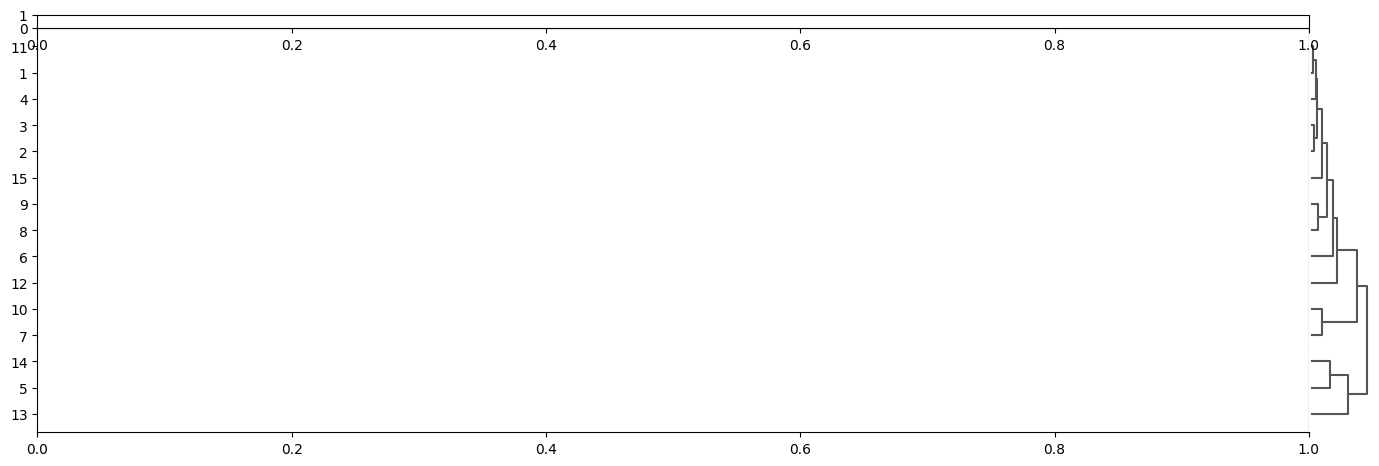

In [66]:
sc.pl.matrixplot(acts, ctypes_dict, 'domain', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [ ]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

In [ ]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['domain']]

In [ ]:
# Visualize
sc.pl.umap(adata, color=['cell_type'],s=20)

In [ ]:
sc.pl.umap(acts, color=adata.obs['cell_type'].unique().tolist() + ['domain'], cmap='RdBu_r', s=10, alpha=0.5, ncols=3)
#sc.pl.violin(acts, keys=['Endothelial cells', 'Astrocytes'], groupby='leiden')

In [ ]:
sc.pl.embedding(adata, basis='X_umap', color=['EPCAM','ERBB2','TP53','KRT7'])

In [ ]:
sc.pl.umap(adata,title="0027465 - Grafiti - Region 1",color=["Treatment"],s=20)

In [ ]:
gf.pl.plot_fraction(adata,category="Treatment",variable="grafiti_motif")
gf.pl.plot_fraction(adata,category="Patient_ID",variable="grafiti_motif")
gf.pl.plot_fraction(adata,category="Sample_ID",variable="grafiti_motif")

In [ ]:
gf.pl.fovs(adata,'grafiti_motif','Sample_ID')

# GraphST - Individual

In [45]:
adata = sc.read_h5ad(f'{datadir}/raw/0027465/0027465_region1.h5ad')
adata

AnnData object with n_obs × n_vars = 46595 × 477
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'log_norm'

In [46]:
adata.var_names_make_unique()

In [47]:
# define and train model
model = GraphST.GraphST(adata)
adata = model.train()

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [17:10<00:00,  1.72s/it]

Optimization finished for ST data!


In [48]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

In [49]:
# the number of clusters
n_clusters = 15

In [50]:
# clustering
from GraphST.utils import clustering
clustering(adata, n_clusters, radius=radius, refinement=False) #For DLPFC dataset, we use optional refinement step.

fitting ...
  |======================================================================| 100%


In [51]:
obs_df = adata.obs.dropna()

In [52]:
umap(adata, encoding_key="emb")

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


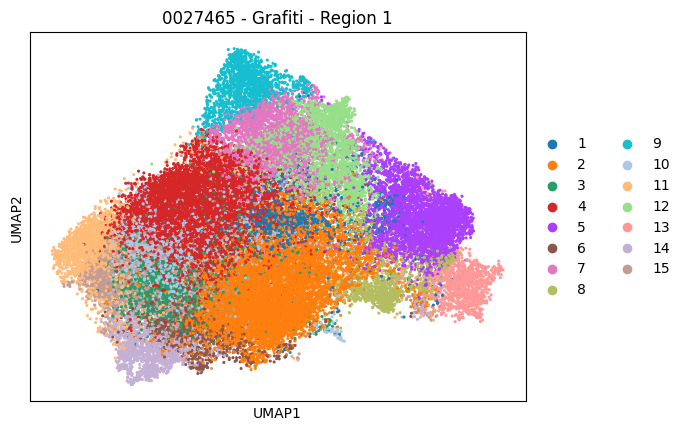

In [53]:
sc.pl.umap(adata,title="0027465 - Grafiti - Region 1",color=["domain"],s=20)

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


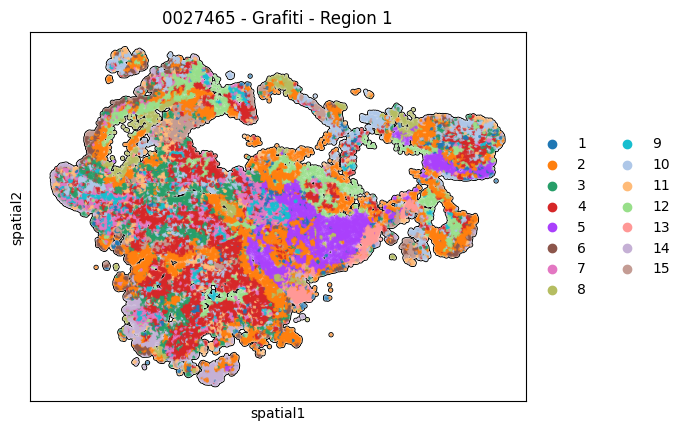

In [54]:
sc.pl.embedding(adata, basis='spatial', title = '0027465 - Grafiti - Region 1', color ='domain', s=20, add_outline=True)

In [68]:
#adata.write(f'{datadir}/graphst/spectrum_graphst_normalized.h5ad')
adata = sc.read_h5ad(f'{datadir}/graphst/spectrum_graphst_normalized.h5ad')

In [56]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]
# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 46595 samples and 477 targets for 24 sources.


100%|██████████| 46595/46595 [00:08<00:00, 5580.78it/s]


In [57]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

In [58]:
df = dc.rank_sources_groups(acts, groupby='domain', reference='rest', method='t-test_overestim_var')

In [59]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{1: ['NK cells', 'Gamma delta T cells', 'T cells'],
 2: ['Beta cells', 'Alpha cells', 'Gamma (PP) cells'],
 3: ['Beta cells', 'Gamma (PP) cells', 'Alpha cells'],
 4: ['Beta cells', 'Gamma (PP) cells', 'Luminal epithelial cells'],
 5: ['Platelets', 'NK cells', 'Gamma delta T cells'],
 6: ['Gamma (PP) cells', 'Beta cells', 'Alpha cells'],
 7: ['Pericytes', 'Mesangial cells', 'Pancreatic stellate cells'],
 8: ['Acinar cells', 'Enterocytes', 'Plasmacytoid dendritic cells'],
 9: ['Endothelial cells', 'Mesangial cells', 'Pericytes'],
 10: ['Beta cells', 'Gamma (PP) cells', 'Alpha cells'],
 11: ['Beta cells', 'Alpha cells', 'Gamma (PP) cells'],
 12: ['Pericytes', 'Pancreatic stellate cells', 'Mesangial cells'],
 13: ['Acinar cells', 'Plasmacytoid dendritic cells', 'Enteroendocrine cells'],
 14: ['Gamma (PP) cells', 'Luminal epithelial cells', 'Alpha cells'],
 15: ['Luminal epithelial cells', 'Beta cells', 'Gamma (PP) cells']}

TypeError: object of type 'int' has no len()

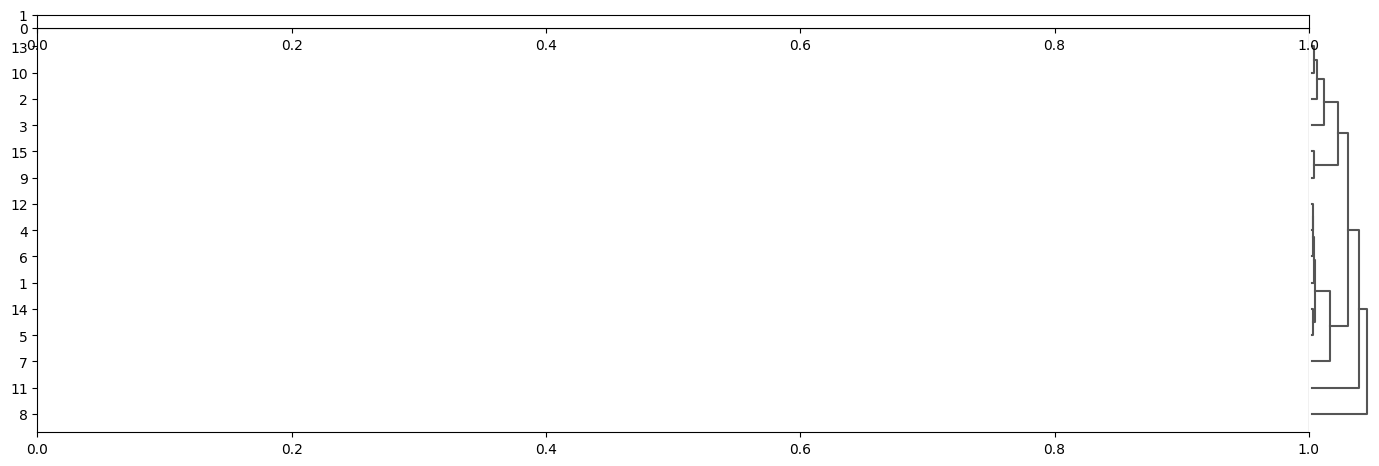

In [71]:
sc.pl.matrixplot(acts, ctypes_dict, 'domain', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [72]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{1: 'Beta cells',
 2: 'Dendritic cells',
 3: 'Acinar cells',
 4: 'Beta cells',
 5: 'Luminal epithelial cells',
 6: 'Luminal epithelial cells',
 7: 'Pulmonary alveolar type II cells',
 8: 'Gamma delta T cells',
 9: 'Pancreatic stellate cells',
 10: 'Acinar cells',
 11: 'Endothelial cells',
 12: 'Luminal epithelial cells',
 13: 'Dendritic cells',
 14: 'Luminal epithelial cells',
 15: 'Pancreatic stellate cells'}

In [75]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['domain']]

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


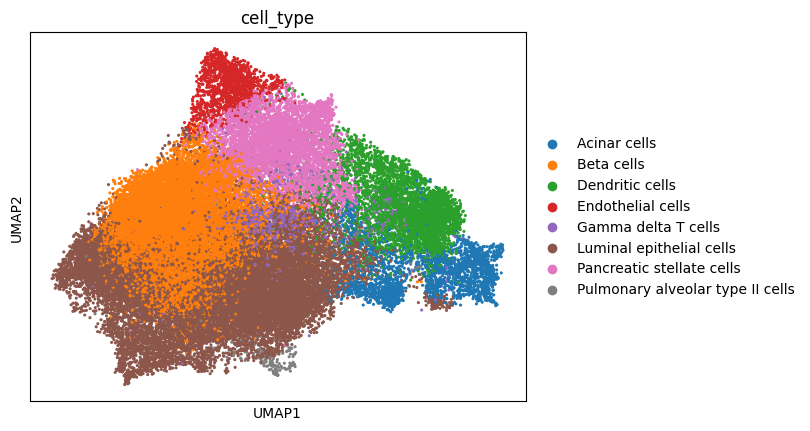

In [76]:
# Visualize
sc.pl.umap(adata, color=['cell_type'],s=20)

/home/mezallj1/miniconda3/envs/graphst/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


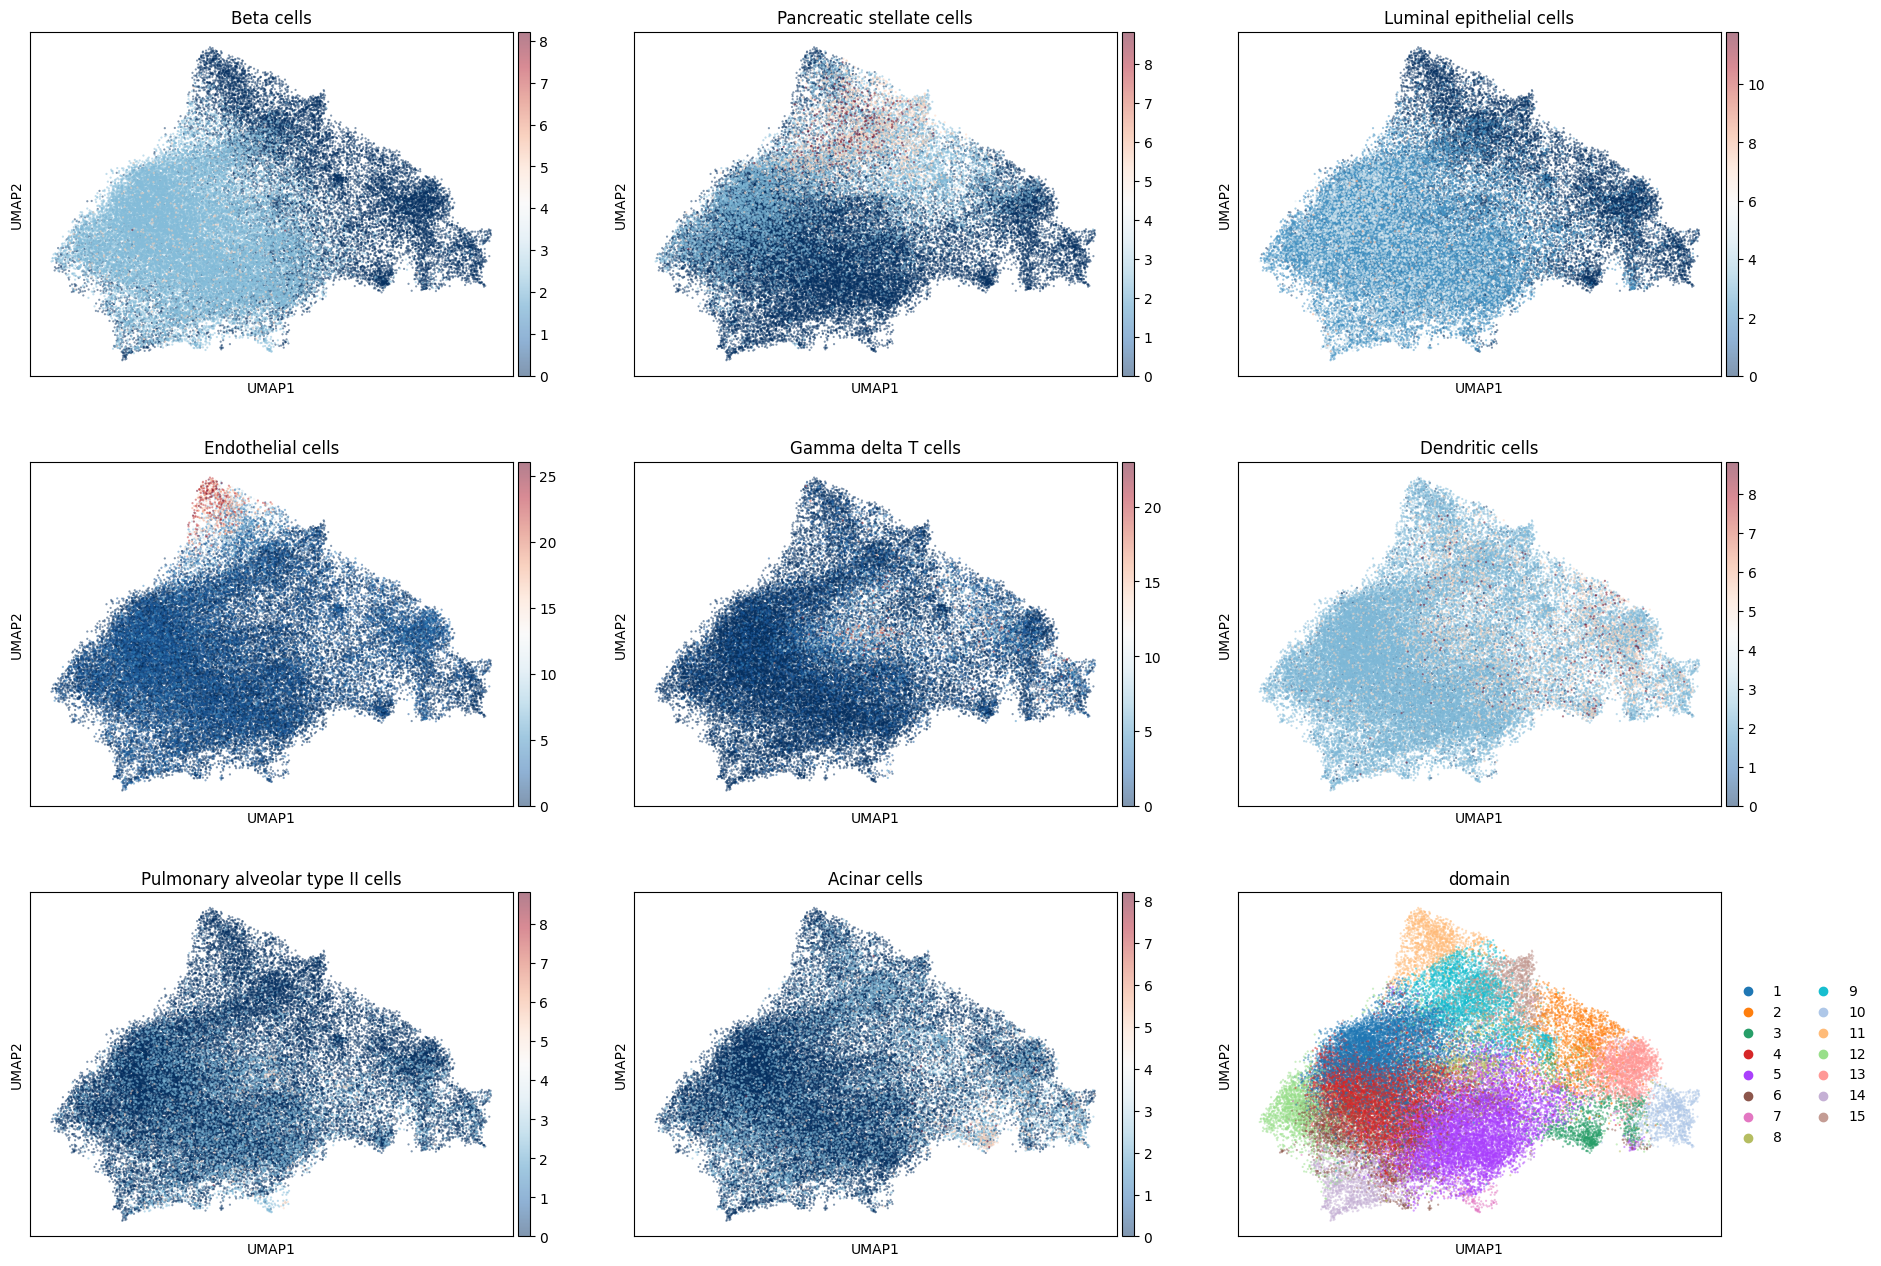

In [77]:
sc.pl.umap(acts, color=adata.obs['cell_type'].unique().tolist() + ['domain'], cmap='RdBu_r', s=10, alpha=0.5, ncols=3)
#sc.pl.violin(acts, keys=['Endothelial cells', 'Astrocytes'], groupby='leiden')

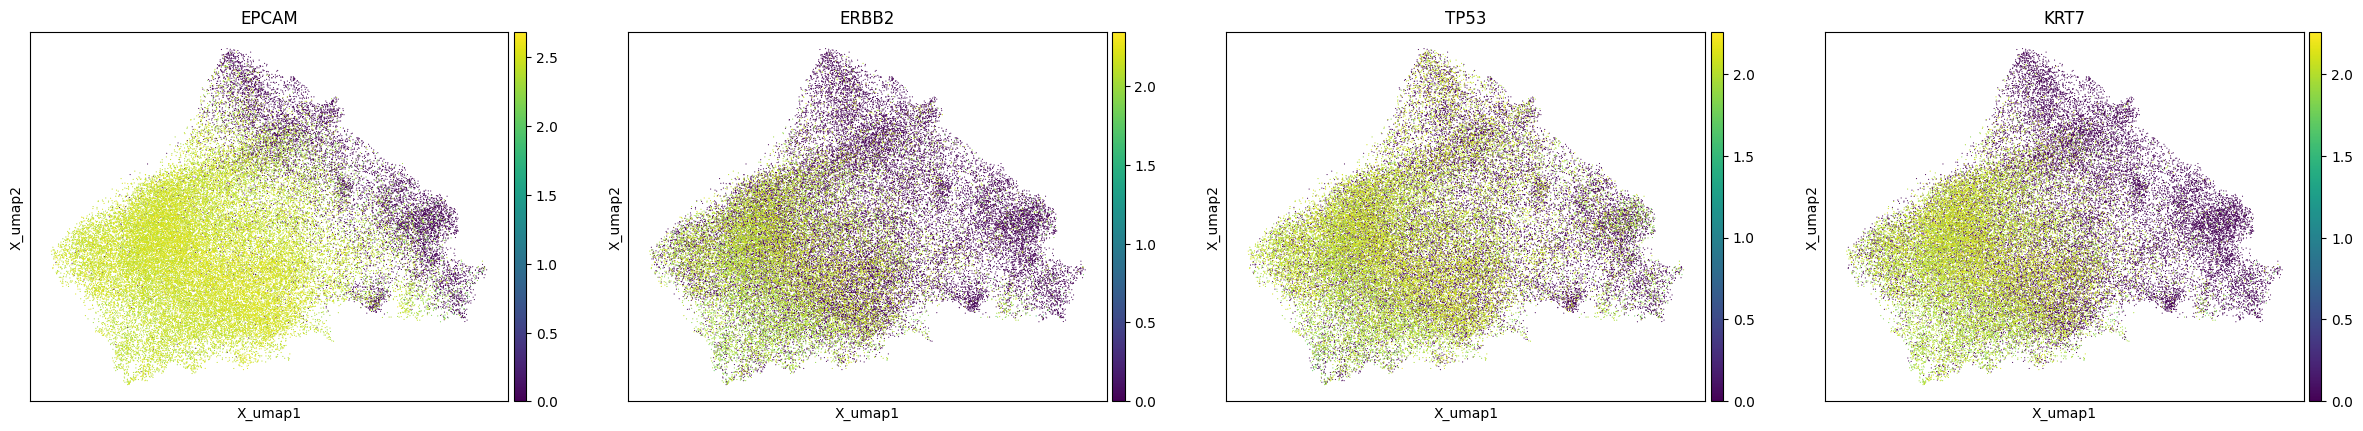

In [60]:
sc.pl.embedding(adata, basis='X_umap', color=['EPCAM','ERBB2','TP53','KRT7'])

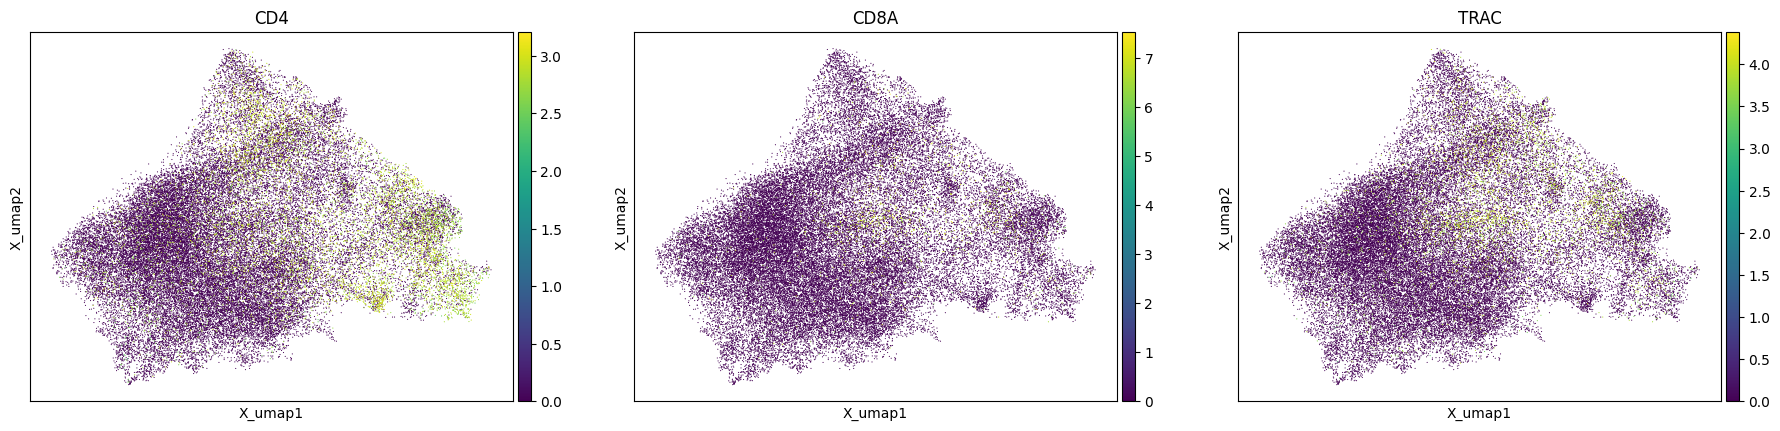

In [69]:
sc.pl.embedding(adata, basis='X_umap', color=['CD4', 'CD8A', 'TRAC'])